# 1. Исследовательский анализ данных

Подключаем библиотеки.

In [3]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Имортируем и смотрим на данные.

In [4]:
photo = pd.read_csv('/datasets/faces/labels.csv')

In [8]:
photo.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [9]:
photo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [11]:
photo.shape

(7591, 2)

Смотрим как распределен целевой признак 'real_age'.

Text(0, 0.5, 'Частота')

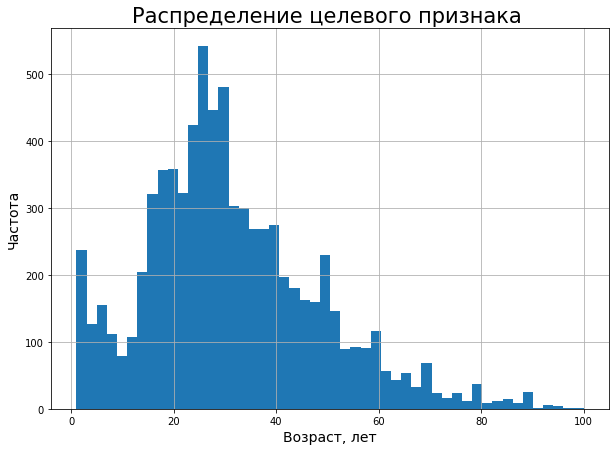

In [20]:
photo['real_age'].hist(bins=50, figsize=(10,7));
plt.title('Распределение целевого признака ', fontsize=21);
plt.xlabel('Возраст, лет', fontsize=14)
plt.ylabel('Частота', fontsize=14)

<b>Из гистограммы распределения возраста видим, что основные данные распределены в возрастном диапазоне 10 - 50 лет, предположительно распознавание возраста вне этого диапазона будет происходить менее точно.

Выведем одну произвольную фотографию, например 000009.jpg.

In [18]:
#image = Image.open('/datasets/faces/final_files/000009.jpg')
#plt.imshow(np.array(image))

Подключаем динамическую загрузку данных 'ImageDataGenerator', который сформирует батчи с изображениями и метками классов.

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=photo,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [8]:
features, target = next(train_gen_flow)

Напечатаем на экране 15 фотографий и посмотрим, как устроен датасет.

In [19]:
#fig = plt.figure(figsize=(10,10))
#for i in range(15):
#    fig.add_subplot(4, 4, i+1)
#    plt.imshow(features[i])
##Для компактности удаляем оси и прижимаем изображения друг к другу
#    plt.xticks([])
#    plt.yticks([])
#    plt.tight_layout()

<b>Наблюдаем, что в датасете имеются цетные фотографии в фас/профиль, черно-белые, некоторые изображения повернуты, на некоторых лицо частично закрыто объектами (микрофон, пузырь от жевачки и пр.)

# 2. Обучение модели

Код в следующей ячейке выполнялся на удаленной вычислительной машине с мощным GPU-адаптером, поэтому ниже будет просто сам код и результат вывода.

```python
from tensorflow import keras
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

 
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

Отметим, что гипераметр - отражение по горизонтали (horizontal_flip=True), используем только на обучающей выборке.

Вывод результата.

```
Train for 356 steps, validate for 119 steps
Epoch 1/15
2020-09-14 13:22:21.899428: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2020-09-14 13:22:26.210568: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 115s - loss: 211.6846 - mae: 10.6036 - val_loss: 342.8734 - val_mae: 13.6825
Epoch 2/15
356/356 - 43s - loss: 83.5044 - mae: 6.9538 - val_loss: 128.5952 - val_mae: 8.6221
Epoch 3/15
356/356 - 42s - loss: 57.5533 - mae: 5.7748 - val_loss: 113.4030 - val_mae: 8.4032
Epoch 4/15
356/356 - 43s - loss: 41.0339 - mae: 4.9054 - val_loss: 90.2606 - val_mae: 7.4251
Epoch 5/15
356/356 - 42s - loss: 32.4065 - mae: 4.3296 - val_loss: 71.7431 - val_mae: 6.2268
Epoch 6/15
356/356 - 42s - loss: 23.7696 - mae: 3.7524 - val_loss: 71.0380 - val_mae: 6.2272
Epoch 7/15
356/356 - 43s - loss: 19.5383 - mae: 3.3593 - val_loss: 67.8080 - val_mae: 6.1246
Epoch 8/15
356/356 - 43s - loss: 16.3821 - mae: 3.0881 - val_loss: 69.7284 - val_mae: 6.4570
Epoch 9/15
356/356 - 42s - loss: 14.3362 - mae: 2.8569 - val_loss: 70.7964 - val_mae: 6.2557
Epoch 10/15
356/356 - 43s - loss: 13.0397 - mae: 2.7656 - val_loss: 66.6664 - val_mae: 6.1902
Epoch 11/15
356/356 - 43s - loss: 12.6585 - mae: 2.6974 - val_loss: 63.3757 - val_mae: 5.9735
Epoch 12/15
356/356 - 42s - loss: 12.5881 - mae: 2.7261 - val_loss: 65.5236 - val_mae: 6.1887
Epoch 13/15
356/356 - 43s - loss: 11.5974 - mae: 2.5897 - val_loss: 63.4278 - val_mae: 5.9279
Epoch 14/15
356/356 - 43s - loss: 11.4288 - mae: 2.5757 - val_loss: 63.5739 - val_mae: 6.0537
Epoch 15/15
356/356 - 43s - loss: 11.4554 - mae: 2.5785 - val_loss: 64.6065 - val_mae: 5.9401
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 64.6065 - mae: 5.9401
Test MAE: 5.9401
```

Метрика MAE на тестовой выборке получилась равна 5.9401.

# 3. Анализ обученной модели

<b>Мы обучили модель с хорошей точностью - метрика MAE на валидационной выборке равна 5,9401. Нейронные сети отлично себя показыают на анализе графической информации, однако, огромная заслуга результатов - в отточенной архитектуре модели, за основу которой мы брали ResNet50, а именно:   
 - модель предобучалась на большом датасете ImageNet, т.е. мы начали обучение сети на ImageNet, а продолжили на нашей задаче, тем самым результат получился лучше, нежели обучать с нуля.   
 - чтобы избежать переобучения и повысить скорость обучения, мы "заморозили" часть сети: некоторые слои оставили с весами из ImageNet, они не будут обучаться градиентным спуском. Чтобы сеть обучалась, добавленный сверху полносвязный слой замораживать не стали.   
 - использовали алгоритм Adam (от англ. adaptive moment estimation, «адаптивность на основе оценки моментов»), который подбирает различные параметры для разных нейронов, что также ускоряет обучение модели. Мы изменили гиперпараметр lr с по умолчанию 0.001 на 0.0001, что улучшило качество модели.   
 - увеличили обучающую выборку путем аугментации - добавили в сет повернутые по горизонтали изображения.